# 💧 VQE-Based Bond Angle Optimization of Water (H₂O)

This notebook implements the **Variational Quantum Eigensolver (VQE)** to determine the **optimal bond angle of the water molecule (H₂O)** by minimizing its ground state energy across a range of geometries. The simulation is executed on a **noiseless quantum device** using PennyLane’s quantum chemistry module.

### Key Features:
- **Geometry Generator**: Constructs H₂O molecular geometries parametrized by bond angle (in degrees) with fixed bond length.
- **VQE Energy Evaluation**:
  - Applies a **UCCSD-style ansatz** with both single and double excitations.
  - Optimizes the ansatz parameters for each bond angle using the **Adam optimizer**.
- **Angle Sweep**: Evaluates the ground state energy at discrete H–O–H angles (from 100° to 109°).
- **Result Visualization**:
  - Plots energy vs. bond angle to identify the minimum.
  - Outputs the **optimal angle** and its corresponding **minimum energy**.

### Purpose:
To estimate the **equilibrium bond angle** of water using a quantum variational approach, enabling quantum simulation-driven geometry optimization — a key step in **ab initio quantum chemistry** using near-term quantum devices.

In [1]:
import pennylane as qml                  # Quantum circuit builder and device management
from pennylane import numpy as np        # Not regular NumPy, but similar and supports automatic differentiation
from pennylane import qchem              # Quantum chemistry module used to define molecule Hamiltonians
from pennylane.qchem import excitations  # Single and double excitations used in the UCCSD (Unitary Coupled Cluster Singles and Doubles) ansatz
import matplotlib.pyplot as plt
import json, os, time
from vqe_utils import excitation_ansatz, get_optimizer, set_seed, make_run_config_dict, run_signature, find_existing_run, save_run_record, ensure_dirs
from vqe_utils import RUNS_DIR, RESULTS_DIR, IMG_DIR

seed = 0
set_seed(seed)  # Reproducible runs
ensure_dirs()   # Creates runs/, results/ and images, if missing

Running VQE for angle 100.0°
[saved] Adam: runs/H2O_BondAngle_100.0deg_Adam_s0__e9f63cbbbcc5.json
[mirrored] results/H2O_BondAngle_100.0deg_Adam_s0__e9f63cbbbcc5.json
Running VQE for angle 102.2°
[saved] Adam: runs/H2O_BondAngle_102.2deg_Adam_s0__bdf93378f427.json
[mirrored] results/H2O_BondAngle_102.2deg_Adam_s0__bdf93378f427.json
Running VQE for angle 104.5°
[saved] Adam: runs/H2O_BondAngle_104.5deg_Adam_s0__2d6a71ad10d0.json
[mirrored] results/H2O_BondAngle_104.5deg_Adam_s0__2d6a71ad10d0.json
Running VQE for angle 106.8°
[saved] Adam: runs/H2O_BondAngle_106.8deg_Adam_s0__6dadf206f5f4.json
[mirrored] results/H2O_BondAngle_106.8deg_Adam_s0__6dadf206f5f4.json
Running VQE for angle 109.0°
[saved] Adam: runs/H2O_BondAngle_109.0deg_Adam_s0__1f6bb93be88f.json
[mirrored] results/H2O_BondAngle_109.0deg_Adam_s0__1f6bb93be88f.json


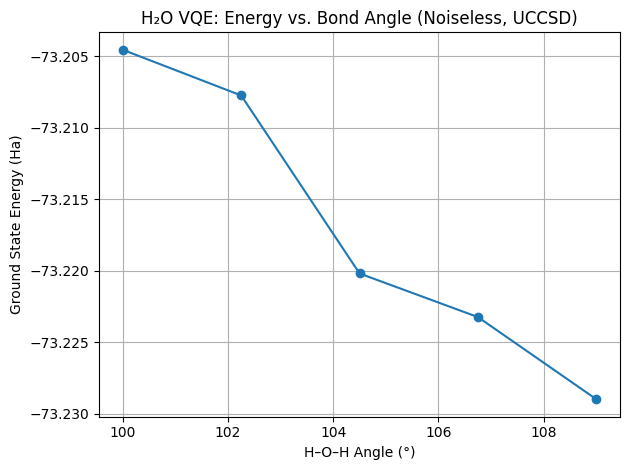

Minimum energy: -73.228975 Ha
Optimal angle: 109.00°


In [2]:
def water_geometry(angle_deg, bond_length=0.9584):
    # Generate coordinates for water with given angle in degrees (bond length in Å)
    angle_rad = np.deg2rad(angle_deg)  # Convert to radians
    x = bond_length * np.sin(angle_rad / 2)
    z = bond_length * np.cos(angle_rad / 2)
    coordinates = np.array([
        [0.0, 0.0, 0.0],  # Oxygen
        [x, 0.0, z],      # Hydrogen 1
        [-x, 0.0, z]      # Hydrogen 2
    ])
    return coordinates

def run_vqe_with_cache(angle_deg, stepsize=0.2, max_iterations=50):
    # Geometry & Hamiltonian for this angle
    coordinates = water_geometry(angle_deg)
    symbols = ["O", "H", "H"]
    basis = "STO-3G"
    hamiltonian, qubits = qchem.molecular_hamiltonian(symbols, coordinates, charge=0, basis=basis)

    electrons = 10
    hf = qchem.hf_state(electrons, qubits)
    singles, doubles = excitations(electrons, qubits)

    # Cost function (UCCSD: singles + doubles)
    dev = qml.device("default.qubit", wires=qubits)
    @qml.qnode(dev)
    def cost_fn(params):
        excitation_ansatz(
            params, wires=range(qubits), hf_state=hf,
            excitations=(singles, doubles), excitation_type="both"
        )
        return qml.expval(hamiltonian)

    # Build config/signature for exact-match reuse
    ansatz_desc = "UCC singles+doubles (excitation_ansatz with (singles, doubles))"
    optimizer_name = "Adam"
    cfg = make_run_config_dict(
        symbols=symbols,
        coordinates=coordinates,
        basis=basis,
        ansatz_desc=ansatz_desc,
        optimizer_name=optimizer_name,
        stepsize=stepsize,
        max_iterations=max_iterations,
        seed=seed,
    )
    sig = run_signature(cfg)

    # Human-readable file includes angle
    fname = os.path.join(RUNS_DIR, f"H2O_BondAngle_{angle_deg:.1f}deg_{optimizer_name}_s{seed}__{sig}.json")
    existing = find_existing_run(RUNS_DIR, sig)

    if existing:
        with open(existing) as f:
            rec = json.load(f)
        print(f"[reuse] angle {angle_deg:.1f}°: loaded {existing}")
        energy = rec["energies"]
        # Params for downstream use (handle old/new schema)
        if "final_params" in rec:
            params = np.array(rec["final_params"], requires_grad=True)
        elif "params_by_step" in rec and rec["params_by_step"]:
            params = np.array(rec["params_by_step"][-1], requires_grad=True)
        else:
            print("[reuse] no params stored; recomputing.")
            existing = None
        
        # Backfill to results/
        if existing:
            base = os.path.basename(existing)
            dest = os.path.join(RESULTS_DIR, base)
            if not os.path.exists(dest):
                with open(dest, "w") as f:
                    json.dump(rec, f, indent=2)
                print(f"[mirrored-existing] {dest}")
    if not existing:
        # Compute results if this configuration has NOT been ran before
        params = np.zeros(len(singles) + len(doubles), requires_grad=True)
        opt = get_optimizer(optimizer_name, stepsize=stepsize)
        energy = [cost_fn(params)]
        for _ in range(max_iterations):
            params, e_prev = opt.step_and_cost(cost_fn, params)
            energy.append(e_prev)
        energy[-1] = float(cost_fn(params))

        run_record = {
            "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
            "molecule": "H2O",
            "symbols": symbols,
            "geometry": coordinates.tolist(),
            "basis": basis,
            "electrons": electrons,
            "num_wires": qubits,
            "ansatz": ansatz_desc,
            "optimizer": {
                "name": optimizer_name,
                "stepsize": stepsize,
                "iterations_planned": max_iterations,
                "iterations_ran": len(energy) - 1,
            },
            "seed": seed,
            "energies": [float(e) for e in energy],
            "final_params": [float(x) for x in params],
            "config_hash": sig,
            "metadata": {"angle_deg": float(angle_deg)},
        }
        persisted = save_run_record(fname, run_record)
        print(f"[saved] {optimizer_name}: {fname}")
        print(f"[mirrored] {persisted}")

    return float(energy[-1]), energy

# Define the angle range and initialize the energy
angles = np.linspace(100, 109, 5)  # Bond angles (in degrees) to test
energies = []

for angle in angles:
    # Iterates over each bond angle
    print(f"Running VQE for angle {angle:.1f}°")

    # Find the optimized ground state energy for that geometry
    final_E, _curve = run_vqe_with_cache(angle, stepsize=0.2, max_iterations=50)
    energies.append(final_E)

# Optimized energy plots
plt.plot(angles, energies, marker="o")
plt.xlabel("H–O–H Angle (°)")
plt.ylabel("Ground State Energy (Ha)")
plt.title("H₂O VQE: Energy vs. Bond Angle (Noiseless, UCCSD)")
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{IMG_DIR}/H2O_Bond_Angle_Scan.png", dpi=300)
plt.show()

# Print the optimum bond-angle and the corresponding energy
energies = np.array(energies)
opt_angle = angles[np.argmin(energies)]
print(f"Minimum energy: {energies.min():.6f} Ha")
print(f"Optimal angle: {opt_angle:.2f}°")